In [3]:
pip install requests pandas matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 70.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 92.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 8.2 MB/s eta 0:00:00


In [10]:
import requests
import pandas as pd

# UN Comtrade Public API Base URL
BASE_URL = "https://comtradeapi.un.org/public/v1/getDATariffline/C/M/HS"

def fetch_comtrade_data(reporter, partner, year, trade_type, classification, product):
    """
    Fetch data from UN Comtrade API.
    Parameters:
        reporter (str): Reporter country code (ISO3 or numeric, e.g., 840 for USA).
        partner (str): Partner country code (ISO3 or numeric, e.g., 0 for World).
        year (str): Year of data (e.g., '2020').
        trade_type (str): Trade type (1 = Imports, 2 = Exports).
        classification (str): Classification type (e.g., 'HS').
        product (str): Product code or 'ALL'.
    Returns:
        DataFrame: Trade data as a pandas DataFrame.
    """
    # Construct the API URL with fixed typeCode, freqCode, and clCode
    url = BASE_URL

    # Define the parameters for the request
    params = {
        "r": reporter,        # Reporter country code
        "p": partner,         # Partner country code
        "ps": year,           # Year
        "rg": trade_type,     # Trade regime (1 = Imports, 2 = Exports)
        "cc": product,        # Product code (ALL = All products or a specific HS code)
        "fmt": "json",        # Response format (json or csv)
    }

    # Make the API request
    response = requests.get(url, params=params)

    # Check the HTTP status code
    if response.status_code == 200:
        try:
            data = response.json()
            # Check if the data contains valid records
            if "data" in data and len(data["data"]) > 0:
                return pd.DataFrame(data["data"])
            else:
                print("No data found for the given parameters.")
                return None
        except ValueError:
            print("Invalid JSON response.")
            return None
    else:
        print(f"Error: {response.status_code} - {response.text}")
        return None

reporter = "840"  # USA
partner = "0"     # World
year = "2020"     # Year
trade_type = "2"  # Exports
classification = "HS"  # Harmonized System
product = "1001"  # Wheat (example product)

# Fetch data from the API
df = fetch_comtrade_data(reporter, partner, year, trade_type, classification, product)

# Display the data if available
if df is not None:
    print(df.head())
else:
    print("No data was returned for the given query.")


         datasetCode typeCode freqCode  period  reporterCode reporterISO  \
0  30008201201092100        C        M  201201             8         ALB   
1  30008201202092100        C        M  201202             8         ALB   
2  30008201203092100        C        M  201203             8         ALB   
3  30008201204092100        C        M  201204             8         ALB   
4  30008201205092100        C        M  201205             8         ALB   

  classificationCode  isOriginalClassification  isExtendedFlowCode  \
0                 H4                      True               False   
1                 H4                      True               False   
2                 H4                      True               False   
3                 H4                      True               False   
4                 H4                      True               False   

   isExtendedPartnerCode  isExtendedPartner2Code  isExtendedCmdCode  \
0                   True                   False   

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


# Display the first few rows of the dataset
print("Original Dataset:")
print(df.head())

# Data Cleaning and Transformation
# Convert the 'period' column to a proper datetime format
if "period" in df.columns:
    df["period"] = pd.to_datetime(df["period"], format="%Y%m", errors="coerce")
    print("\nDataset after converting 'period' column to datetime:")
    print(df[["period"]].head())

# Drop unnecessary columns
columns_to_drop = [
    "isExtendedFlowCode", "isExtendedPartnerCode", "datasetChecksum",
    "isExtendedCmdCode", "isExtendedPartner2Code", "isExtendedMotCode",
    "isExtendedCustomsCode"
]
df = df.drop(columns=[col for col in columns_to_drop if col in df.columns], errors="ignore")

# Display the cleaned dataset
print("\nCleaned Dataset:")
print(df.head())

# Summarize the Data
# Aggregate total records by reporterISO
summary = df.groupby("reporterISO")["totalRecords"].sum().reset_index()
summary = summary.sort_values("totalRecords", ascending=False)

print("\nAggregated Total Records by Reporter Country:")
print(summary)

# Save Processed Data
processed_file = "comtrade-output.csv"
df.to_csv(processed_file, index=False)
print(f"\nProcessed data saved to '{processed_file}'.")


Original Dataset:
         datasetCode typeCode freqCode     period  reporterCode reporterISO  \
0  30008201201092100        C        M 2012-01-01             8         ALB   
1  30008201202092100        C        M 2012-02-01             8         ALB   
2  30008201203092100        C        M 2012-03-01             8         ALB   
3  30008201204092100        C        M 2012-04-01             8         ALB   
4  30008201205092100        C        M 2012-05-01             8         ALB   

  classificationCode  isOriginalClassification  totalRecords  lengthCmdCode  \
0                 H4                      True         15051              8   
1                 H4                      True         16674              8   
2                 H4                      True         19058              8   
3                 H4                      True         18224              8   
4                 H4                      True         20452              8   

                 firstReleased  

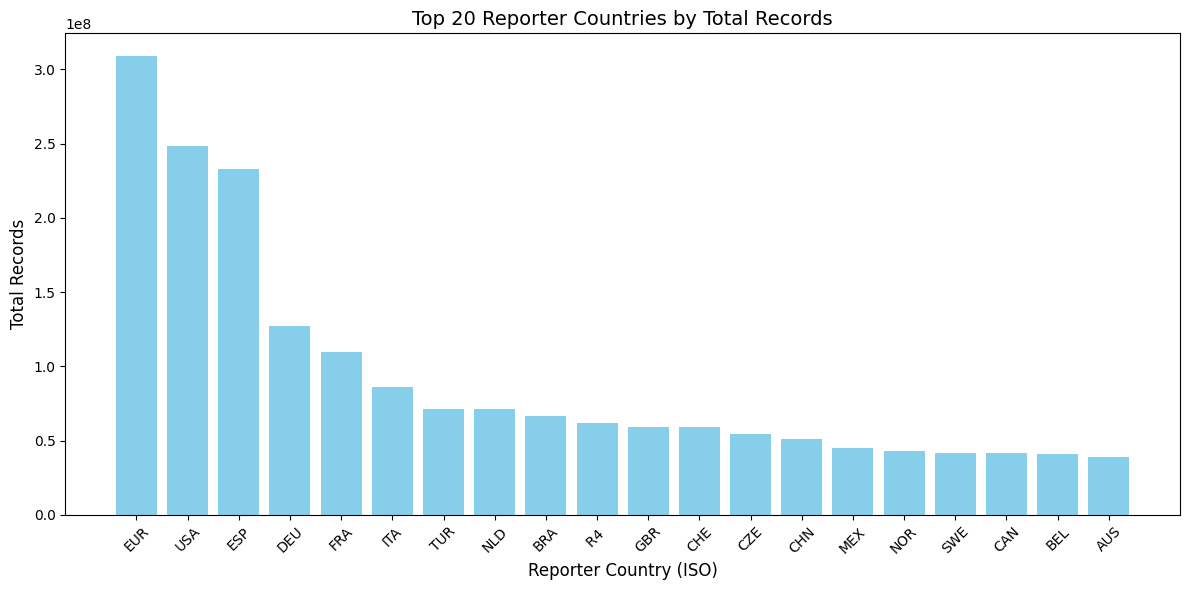

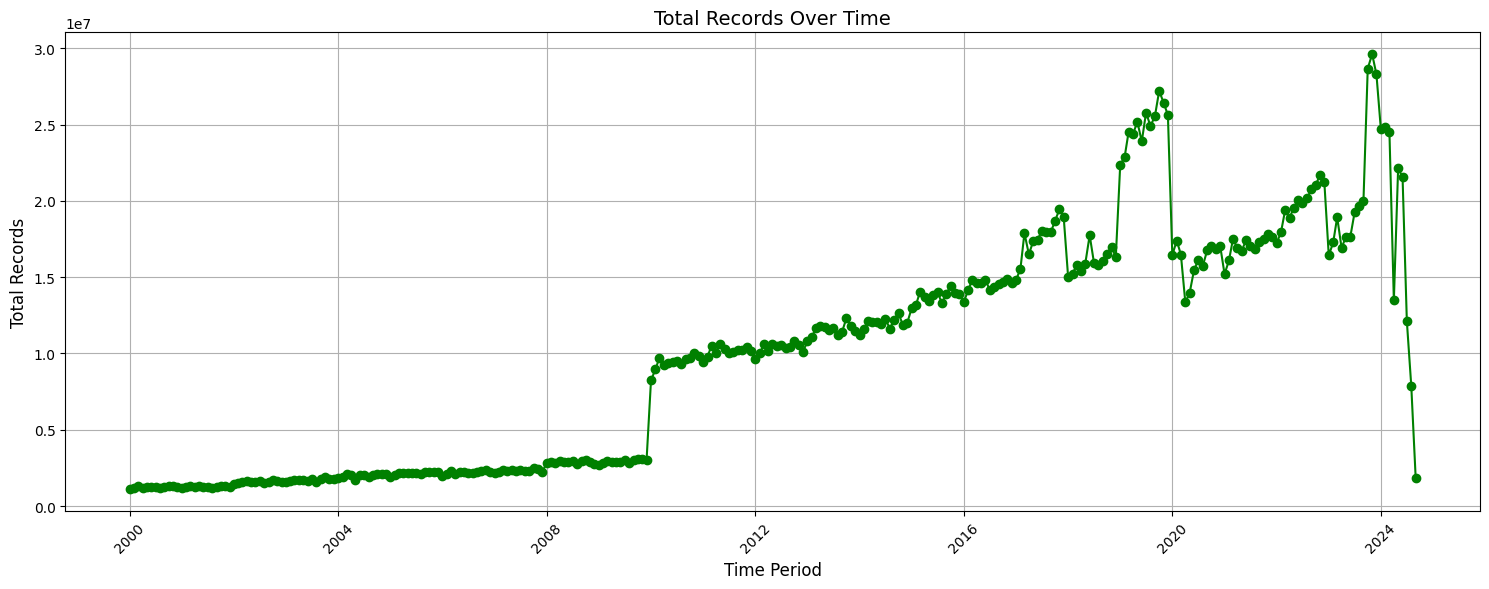

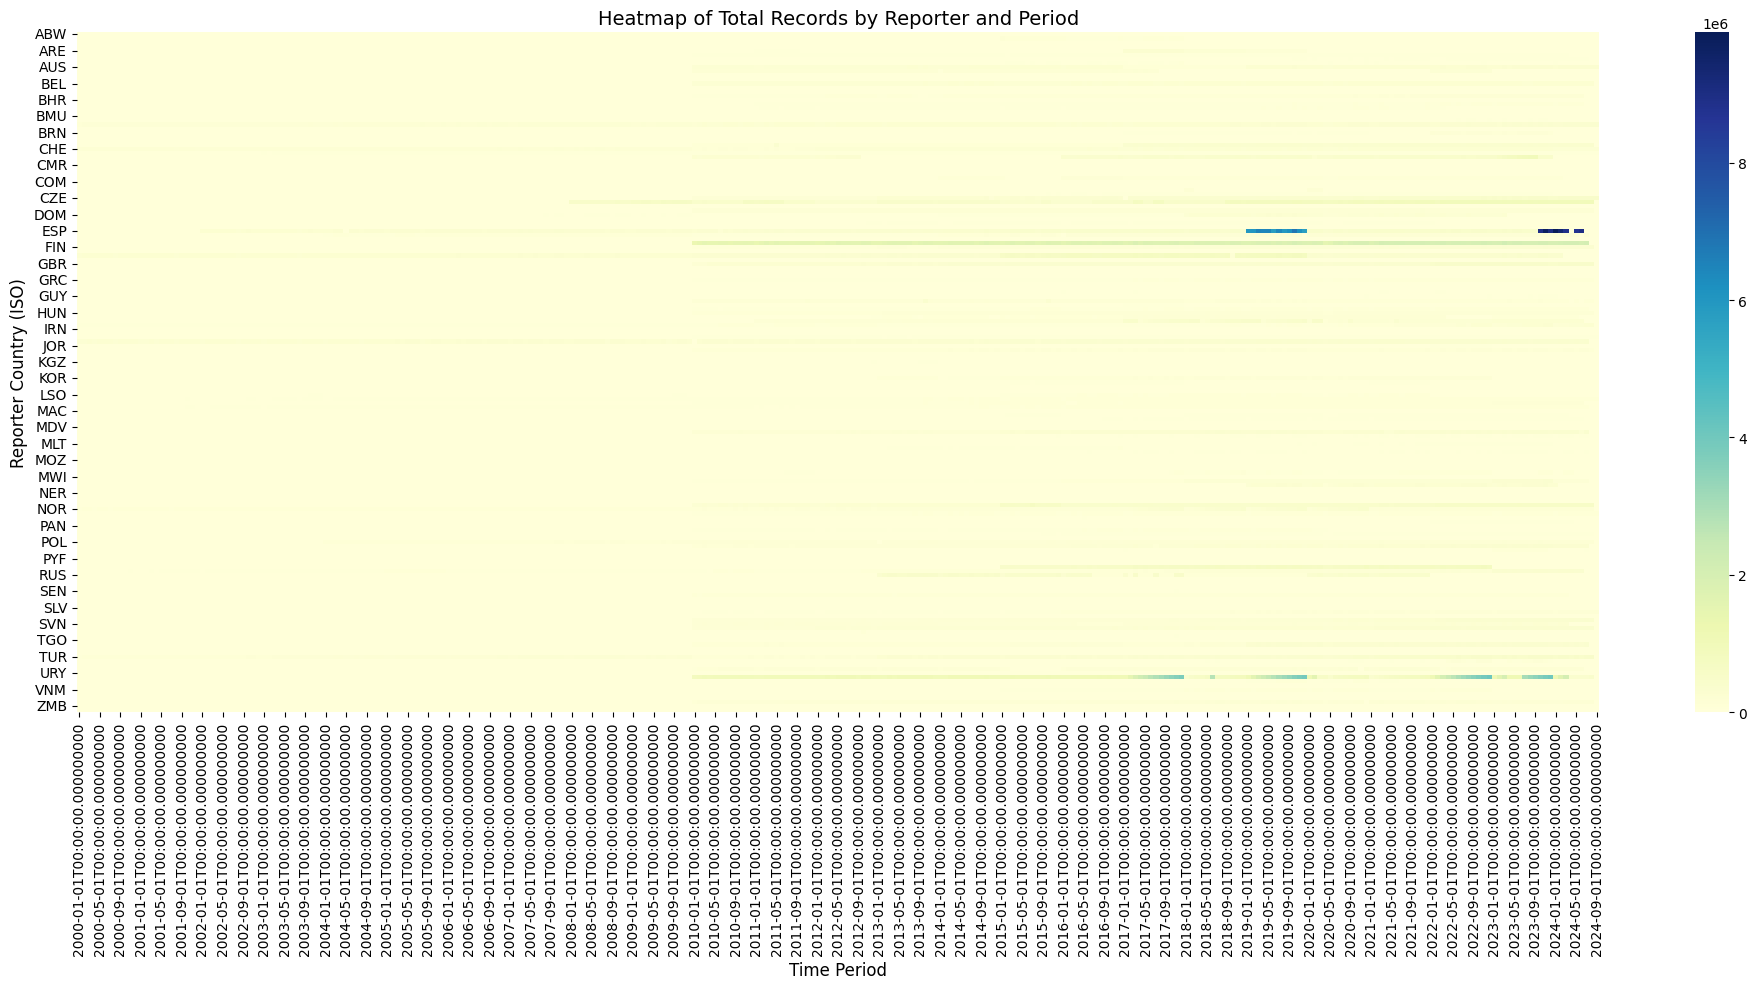

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Bar Plot (Total Records by Reporter Country)
def plot_bar_chart(data, top_n=20):
    """
    Create a bar plot for total records by reporter country.
    Only displays the top N countries by total records.
    """
    # Aggregate total records by Reporter ISO
    aggregated_data = data.groupby("reporterISO")["totalRecords"].sum().reset_index()
    aggregated_data = aggregated_data.sort_values("totalRecords", ascending=False)

    # Limit to the top N countries
    top_countries = aggregated_data.head(top_n)

    # Plot
    plt.figure(figsize=(12, 6))
    plt.bar(top_countries["reporterISO"], top_countries["totalRecords"], color="skyblue")
    plt.title(f"Top {top_n} Reporter Countries by Total Records", fontsize=14)
    plt.xlabel("Reporter Country (ISO)", fontsize=12)
    plt.ylabel("Total Records", fontsize=12)
    plt.xticks(rotation=45, fontsize=10)
    plt.tight_layout()
    plt.show()



# Step 2: Line Plot (Total Records Over Time)
def plot_line_chart(data):
    if "period" in data.columns:
        # Aggregate total records over time
        time_series_data = data.groupby("period")["totalRecords"].sum().reset_index()

        # Plot
        plt.figure(figsize=(15, 6))
        plt.plot(time_series_data["period"], time_series_data["totalRecords"], marker="o", color="green")
        plt.title("Total Records Over Time", fontsize=14)
        plt.xlabel("Time Period", fontsize=12)
        plt.ylabel("Total Records", fontsize=12)
        plt.grid(True)
        plt.xticks(rotation=45, fontsize=10)
        plt.tight_layout()
        plt.show()

# Step 3: Heatmap (Total Records by Reporter and Period)
def plot_heatmap(data):
    if "reporterISO" in data.columns and "period" in data.columns:
        # Create a pivot table for the heatmap
        heatmap_data = data.pivot_table(
            index="reporterISO", columns="period", values="totalRecords", aggfunc="sum", fill_value=0
        )

        # Plot
        plt.figure(figsize=(20, 10))
        sns.heatmap(heatmap_data, cmap="YlGnBu", cbar=True, annot=False)
        plt.title("Heatmap of Total Records by Reporter and Period", fontsize=14)
        plt.xlabel("Time Period", fontsize=12)
        plt.ylabel("Reporter Country (ISO)", fontsize=12)
        plt.xticks(rotation=90, fontsize=10)
        plt.tight_layout()
        plt.show()

# Call the visualization functions
plot_bar_chart(df)
plot_line_chart(df)
plot_heatmap(df)
